In [1]:
# import packages
import re,os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import clear_output
import pandas as pd
import math
import random
from datetime import datetime
from tqdm import trange
tfk = tf.keras
tfkl = tf.keras.layers
clear_output()
# import my files
from symae_model import SymAE
from plot_save import plot_save

Num GPUs Available:  2
TensorFlow Version:  2.9.1


In [83]:
# Generate the Dataset
# 是NN记住了所有state，因为这里的symmetry是完全缠在一起
# 有可能它只是记住了输入
# 不不关心latent space的
n1 = 3 #ne
n2 = 100
nx = 1000
nt = 20
p = 1
q = 10
dropout_rate = 0.5
states = np.arange(n1)+1
nuisances = np.arange(n2)+1
X = np.empty((nx,nt,1), dtype = float, order = 'C')
X_states = np.empty(nx)
X_nuisances = np.empty((nx,nt))
D = np.tensordot(states,nuisances,0)
for i in range(nx):
    e=i%n1
    e = np.random.choice(range(n1))
    X_states[i]=states[e]
    c = np.random.choice(range(n2),replace=False,size=nt)
    X_nuisances[i,:]=nuisances[c]
    for t in range(nt):
        X[i,t,0] = D[e,c[t]]

In [59]:
# Initialize SymAE
model = SymAE(nx,nt,p,q,dropout_rate)
#model.load_weights('./checkpoints/'+datetime.now().strftime("%B%d"))
#model.load_weights('./checkpoints/'+'June16')
#clear_output()

In [84]:
Adam = tf.keras.optimizers.Adam(learning_rate=0.0001,beta_1=0.9,beta_2=0.999,epsilon=1e-07)
model.compile(loss='mse',optimizer=Adam)

In [86]:
# Train the NeuralNet
M=200
epochs=range(M)
losses=[0.0]*M
class CustomCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        losses[epoch]=logs["loss"]
        print("For epoch {:d}, loss is {:f}.".format(epoch, logs["loss"]))
history=model.fit(X,X,epochs=M,verbose=0,callbacks=[CustomCallback()])

For epoch 3, loss is 153.380402.


KeyboardInterrupt: 

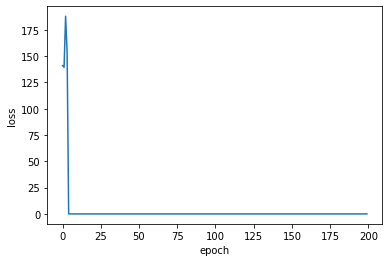

In [87]:
plt.plot(epochs,losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

In [88]:
# Save weights
model.save_weights('./checkpoints/'+datetime.now().strftime("%B%d"))
print("weights saved")

weights saved


32/32 [==============================] - 0s 6ms/step


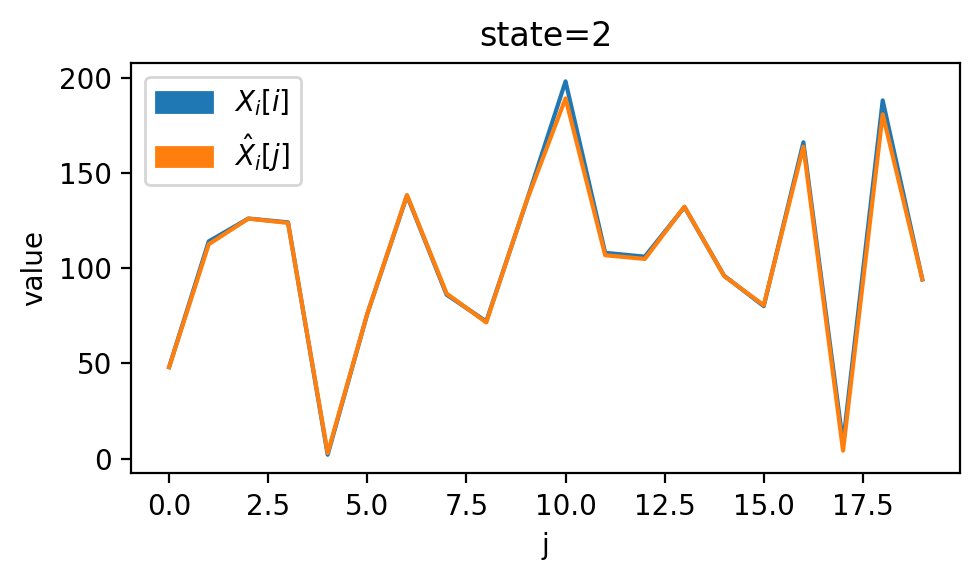

In [111]:
# Plot the result
Y=model.predict(X)
i=0
plt.figure(figsize=(5,3),dpi=200)
plt.plot(range(nt),X[i,:,0])
plt.plot(range(nt),Y[i,:,0])
plt.title('state=%d'%(X_states[i]))
blue_patch = mpatches.Patch(color='C0', label='$X_i[i]$')
orange_patch = mpatches.Patch(color='C1', label='$\hat{X}_i[j]$')
plt.legend(handles=[blue_patch,orange_patch])
plt.xlabel('j')
plt.ylabel('value')
fig=plt.gcf()
plt.tight_layout()
plt.show()

In [128]:
# Save plot
plot_save(fig,ID=-1)

Saved as plot_36.png


In [115]:
X_states[0:10]

array([2., 3., 1., 1., 3., 1., 1., 1., 3., 2.])

In [74]:
# Redatuming
Z=np.empty((nx,nx,nt))
Z_hat=np.empty((nx,nx,nt))
Cs=model.sym_encoder.predict(X, verbose=0)
Ns=model.nui_encoder.predict(X, verbose=0)
for i in trange(5):
    for i_prime in range(5):
        for j in range(nt):
            coherent_i_prime=Cs[i_prime:i_prime+1,:]
            nuisance_i_j=Ns[i_prime:i_prime+1,:]
            merger = model.latentcat(coherent_i_prime,nuisance_i_j)
            Z_hat[i,i_prime,j]=model.decoder.predict(merger, verbose=0)[0,j,0]
            Z[i,i_prime,j]=X_states[i_prime]*X_nuisances[i,j] 

100%|█████████████████████████████████████████████| 5/5 [00:30<00:00,  6.02s/it]


In [68]:
def CEnc(Array_1D_len_nt,j=-1):
    return model.sym_encoder.predict(Array_1D_len_nt[np.newaxis, :, np.newaxis],verbose=0)[0,:]
def NEnc(Array_1D_len_nt,j):
    return model.nui_encoder.predict(Array_1D_len_nt[np.newaxis, :, np.newaxis],verbose=0)[0,j*q : (j+1)*q]

3.0
57.0
[4.252987]
[ 0.6268919   0.6446257  -0.7637985   0.75133765 -0.57880646  1.0154635
  0.5669041   0.67281246  0.6701221  -0.46233073]
176.0
46.0


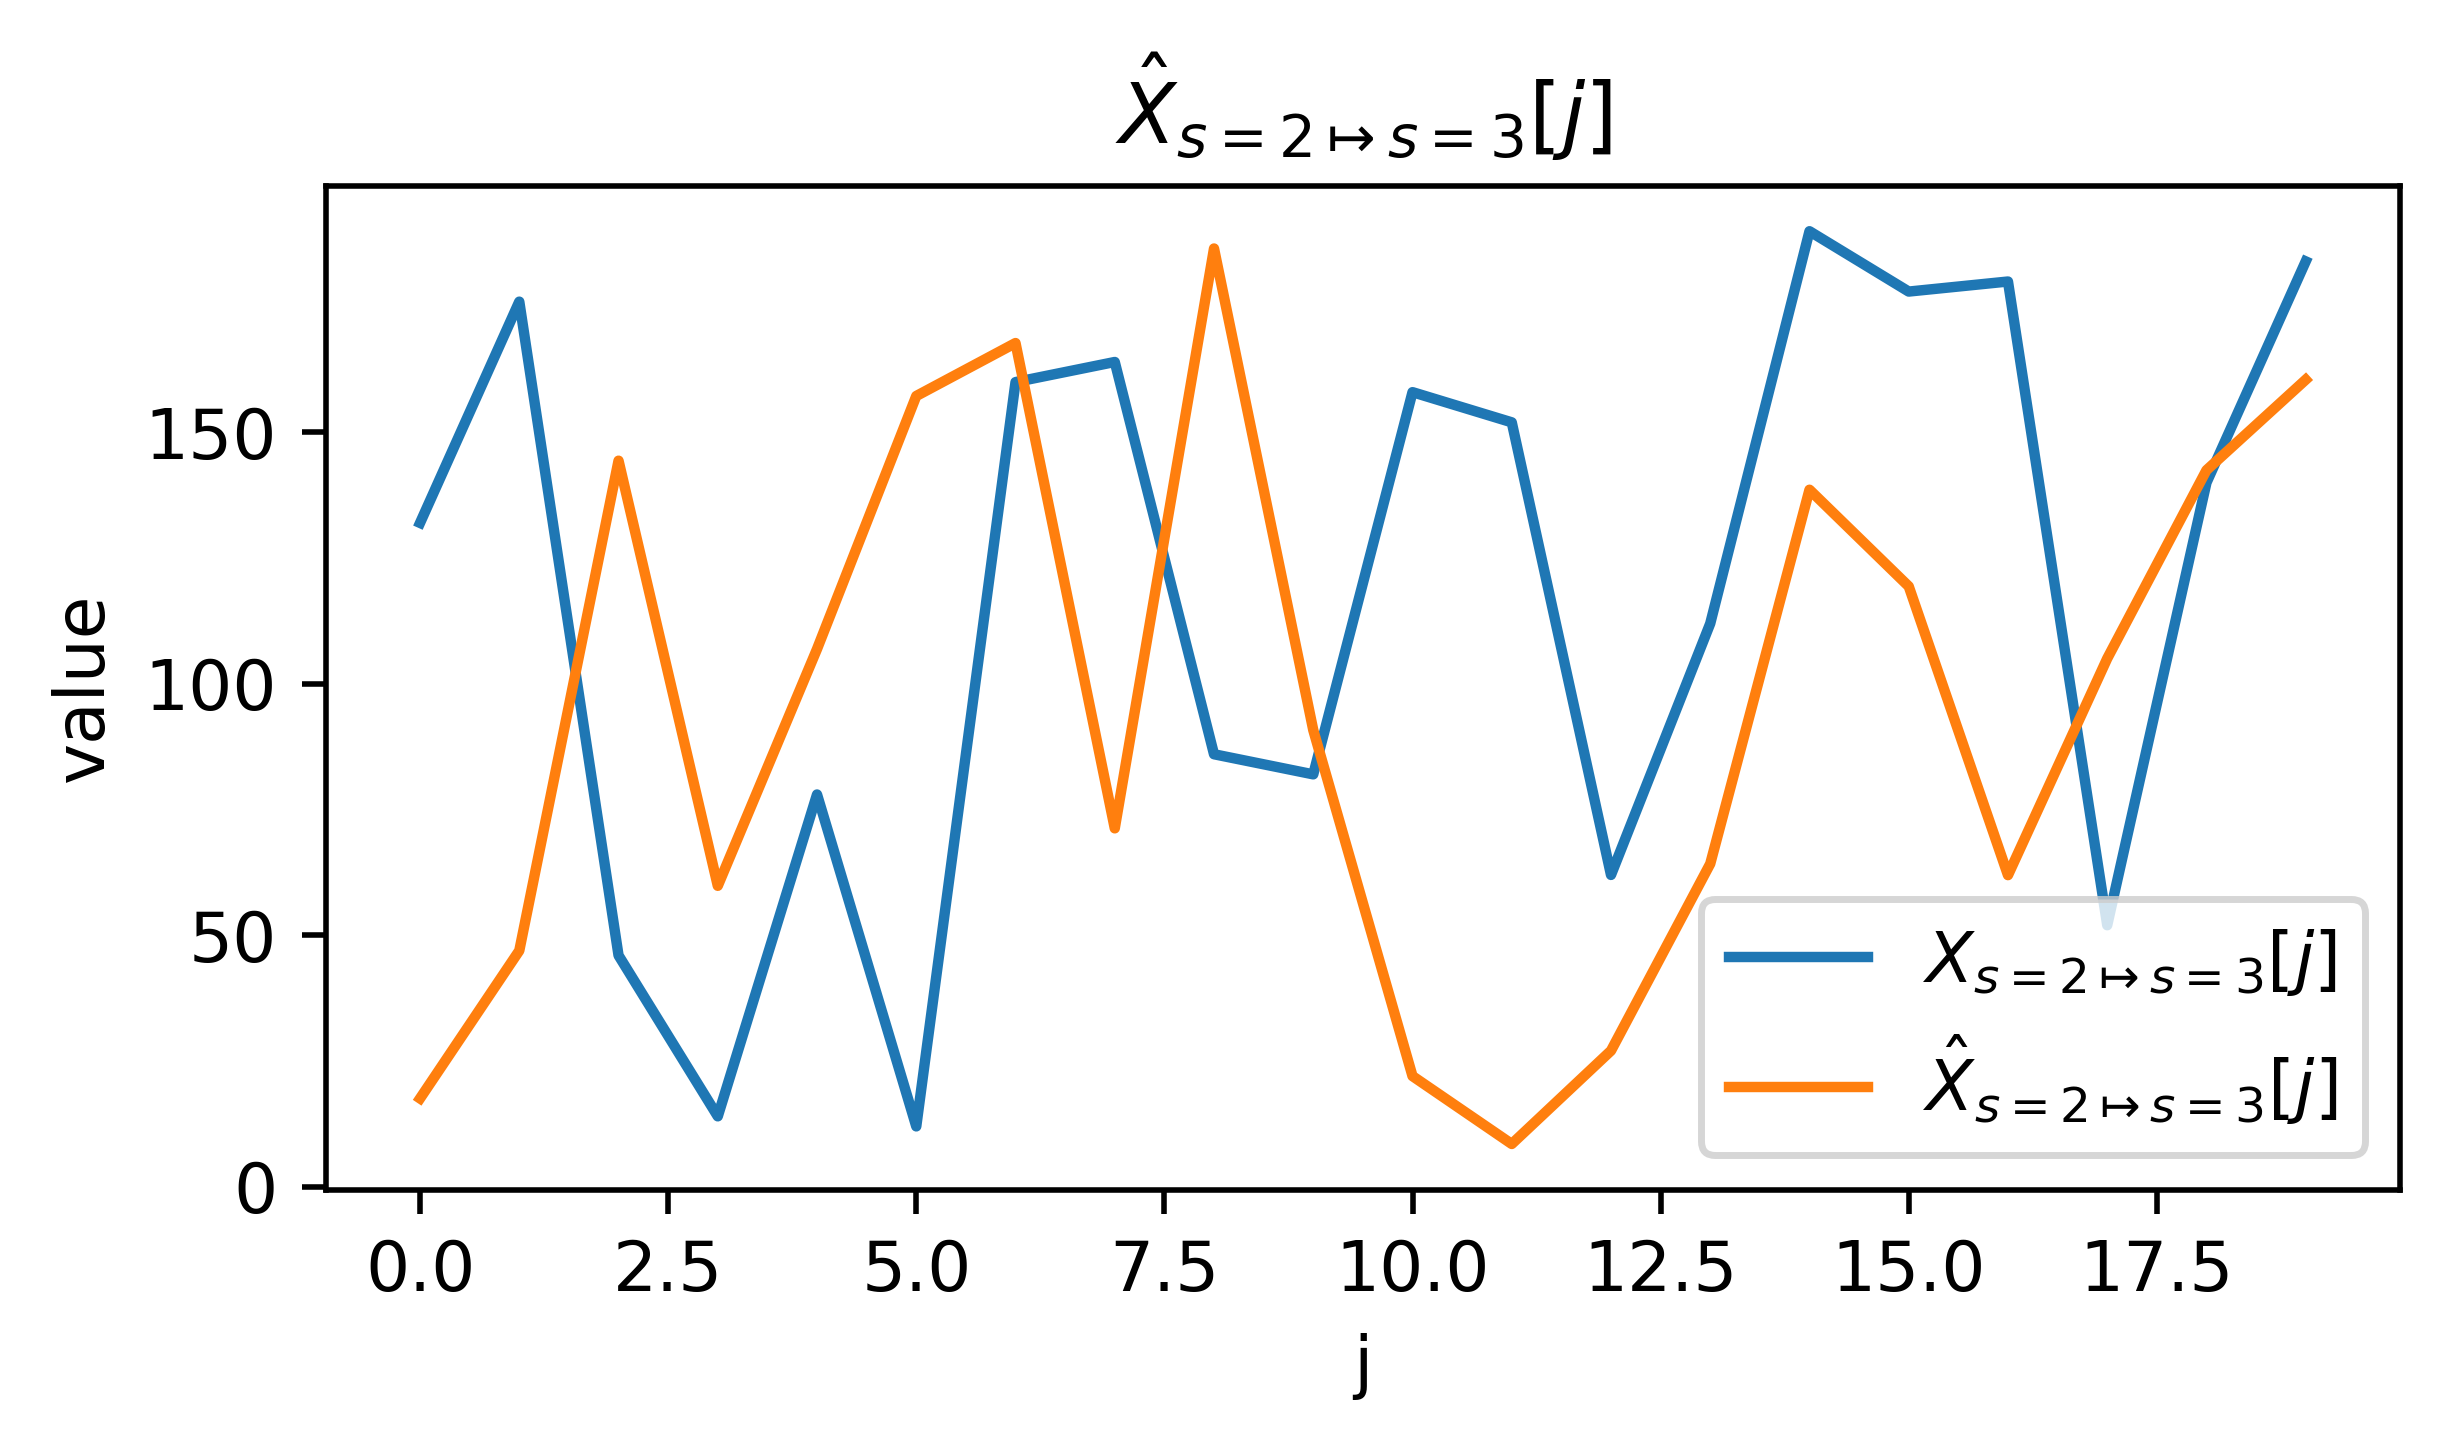

In [130]:
i = 0
i_prime = 1
j = 1
Input = Z[i,i_prime,:]
print( X_states[i_prime] )
print( X_nuisances[i,j] )
print( CEnc(Input,j) )
print( NEnc(Input,j) )
print( Z[i,i_prime,j] )
print( np.floor(Z_hat[i,i_prime,j]) )
fig=plt.figure(figsize=(5, 3), dpi=500)
plt.plot(range(nt),Z[i,i_prime,:],label='${X}_{s=%d \mapsto s=%d}[j]$'%(X_states[i],X_states[i_prime]))
plt.plot(range(nt),Z_hat[i,i_prime,:],label='$\hat{X}_{s=%d \mapsto s=%d}[j]$'%(X_states[i],X_states[i_prime]))
plt.legend()
plt.title('$\hat{X}_{s=%d \mapsto s=%d}[j]$'%(X_states[i],X_states[i_prime]))
plt.ylabel('value')
plt.xlabel('j')
plt.tight_layout()

In [132]:
# Save plot
plot_save(fig,ID=-1)

Saved as plot_37.png


In [82]:
5%3

2